# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv',
    encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9233,15003,59955,"Richmond, BC",20-03-2020,Cool #daffodils are blooming! Come and get som...,Extremely Positive
25831,35436,80388,"Linn, Missouri, USA",07-04-2020,While oil prices plummet as does natural gas n...,Positive
333,4208,49160,Central African Republic,16-03-2020,"""In Gabon, pangolin sales falter with Covid-19...",Positive
31214,42195,87147,NaN,11-04-2020,"So, because of the KARACHI, store can not rest...",Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df["Sentiment"] = df["Sentiment"].replace(
    {"Positive": 1, "Extremely Positive": 1, "Negative": 0, "Extremely Negative": 0})
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12637,19118,64070,"Waukee, Iowa",22-03-2020,@IAGovernor Shut It Down.. us as many people a...,0
27310,37294,82246,"San Diego, CA",08-04-2020,Thank you all grocery store workers your work ...,1
27865,37965,82917,"Miami, FL",08-04-2020,Remember price gouging during a state of emerg...,0
27724,37781,82733,New Mexico,08-04-2020,Coronavirus update Pelosi says US must move to...,1


Сбалансированы ли классы?

In [4]:
print(f"Положительная окраска {(df["Sentiment"] == 1).sum(axis=0)}")
print(f"Отрицательная окраска {(df["Sentiment"] == 0).sum(axis=0)}")
# Не идеально, но сбалансированные. 17 процентов разницы между классами должно быть нормально

Положительная окраска 18046
Отрицательная окраска 15398


**Ответ:** Не идеально, но сбалансированные. 17 процентов разницы между классами должно быть нормально-

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
display(df.isnull().sum())
# Есть пропуски в столбце местоположения (Location)
df = df.fillna("Unknown")
display(df.isnull().sum())

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(["Sentiment"], axis=1), df["Sentiment"], test_size=0.3,
                                                    random_state=0)
#stratify=df["Sentiment"] убрал стратифай, так как про него не сказано. Но стоило бы его добавить
display(X_train.sample(4))
display(X_test.sample(4))
display(y_train.sample(4))
print(f"Положительная окраска {(y_train == 1).sum(axis=0)}")  # убедиться, что стратифай оставляет баланс классов
print(f"Отрицательная окраска {(y_train == 0).sum(axis=0)}")
display(y_test.sample(4))
print(f"Положительная окраска {(y_test == 1).sum(axis=0)}")
print(f"Отрицательная окраска {(y_test == 0).sum(axis=0)}")

,UserName,ScreenName,Location,TweetAt,OriginalTweet
22228,30950,75902,Unknown,03-04-2020,We see team medical profs 1st responders truck...
12559,19024,63976,Detroit,22-03-2020,Probably one of the most important #websites o...
3472,8015,52967,Unknown,18-03-2020,"@Egoli170 For more information on COVID-19, co..."
20099,28305,73257,Earth,26-03-2020,19 Get protected face masks on stock regular ...


,UserName,ScreenName,Location,TweetAt,OriginalTweet
19647,27722,72674,Deutschland,26-03-2020,A senior economist from the United Nation's (U...
32739,44069,89021,WORLDWIDE,13-04-2020,Measures to slow the spread of the #coronaviru...
1247,5311,50263,"El Paso, TX",17-03-2020,"Ya'll, I'm braving the grocery store after wor..."
10520,16561,61513,"Sydney, New South Wales",21-03-2020,Do not go on social media if you are: \r\r\n- ...


5515     1
15836    0
17091    1
21039    0
Name: Sentiment, dtype: int64

Положительная окраска 12564
Отрицательная окраска 10846


6853     1
26921    1
14276    1
3368     0
Name: Sentiment, dtype: int64

Положительная окраска 5482
Отрицательная окраска 4552


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [7]:
from collections import Counter

# Токены я брал только из столбца самих текстов OriginalTweet, так как остальные столбцы не несут в себе эмоциональной окраски

dictionary = Counter(item.lower() for ls in map(lambda x: x.split(), X_train.OriginalTweet) for item in ls)
display(dictionary)

Counter({'the': 26815,
         'to': 23373,
         'and': 14684,
         'of': 13012,
         'a': 11737,
         'in': 11198,
         'for': 8566,
         '#coronavirus': 8223,
         'is': 7383,
         'are': 7050,
         'you': 5467,
         'on': 5452,
         'i': 5340,
         'at': 4642,
         'this': 4581,
         'with': 4063,
         'prices': 3891,
         'food': 3820,
         'we': 3787,
         'have': 3770,
         'that': 3741,
         'as': 3694,
         'be': 3570,
         'grocery': 3469,
         'supermarket': 3288,
         'people': 3175,
         'covid-19': 3173,
         'store': 3155,
         'it': 3150,
         'from': 3045,
         'all': 2808,
         'your': 2784,
         'will': 2726,
         'not': 2714,
         '#covid19': 2471,
         'our': 2460,
         'my': 2445,
         '&amp;': 2314,
         'they': 2309,
         'has': 2304,
         'consumer': 2245,
         'by': 2236,
         'or': 2234,
         '

Какой размер словаря получился?

In [8]:
len(dictionary)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [9]:
dictionary.most_common(10)
# самыми популярными оказались токены артиклей и предлогов. То есть стоп-слова, не несущие информации

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** самыми популярными оказались токены артиклей и предлогов. То есть стоп-слова, не несущие информации

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать о нем?

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

True

In [11]:
words = [item.lower() for ls in map(lambda x: x.split(), X_train.OriginalTweet) for item in ls]
# сделаю из списка слов множество для адекватной асимптотики
stopwords_set = set(stopwords.words("english"))
dictionary = Counter(word for word in words if word not in stopwords_set)
display(dictionary)

Counter({'#coronavirus': 8223,
         'prices': 3891,
         'food': 3820,
         'grocery': 3469,
         'supermarket': 3288,
         'people': 3175,
         'covid-19': 3173,
         'store': 3155,
         '#covid19': 2471,
         '&amp;': 2314,
         'consumer': 2245,
         '19': 2111,
         'covid': 1769,
         'get': 1759,
         '#covid_19': 1660,
         'online': 1648,
         'shopping': 1621,
         'like': 1550,
         'need': 1549,
         'panic': 1495,
         '-': 1429,
         'hand': 1382,
         'demand': 1345,
         '?': 1320,
         'help': 1282,
         'us': 1247,
         'go': 1245,
         'workers': 1242,
         'going': 1141,
         'time': 1136,
         'one': 1074,
         'sanitizer': 1064,
         'stock': 1063,
         'please': 1061,
         'due': 1059,
         'pandemic': 1026,
         'coronavirus': 970,
         'home': 959,
         '#covid2019': 915,
         'buying': 911,
         'oil': 9

In [12]:
len(dictionary)  # удалили 171 уникальный токен

79584

In [13]:
dictionary.most_common(10)
# Новые слова уже более осмысленные. Конечно также встречается шум для задачи определения настроения, связанный с коронавирусом, но также есть и важные слова вроде цен, магазинов и продуктов, дающие информацию о возможном повышении цен или карантине

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** Новые слова уже более осмысленные конечно также встречается шум для задачи определения настроения, связанный с коронавирусом, но также есть и важные слова вроде цен, магазинов и продуктов, дающие информацию о возможном повышении цен или карантине

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [14]:
dictionary.most_common()[:-20:-1]
# Самых популярных слов гораздо больше 20. Часто они содержат ссылки, хештеги, теги, синтаксические ошибки или просто слова с уникальным символом после него. Думаю стоит отделить символы от слов, чтобы слова с символами не были уникальными токенами. Также регулярными выражениями можно легко удалить ссылки, теги и хештеги.

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersã\x82â\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1)]

**Ответ:** Самых популярных слов гораздо больше 20. Часто они содержат ссылки, хештеги, теги, синтаксические ошибки или просто слова с уникальным символом после него. Думаю стоит отделить символы от слов, чтобы слова с символами не были уникальными токенами. Также регулярными выражениями можно легко удалить ссылки, теги и хештеги.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [15]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
dictionary = Counter([item.lower() for ls in map(lambda x: tw.tokenize(x), X_train.OriginalTweet) for item in ls])
dictionary.most_common(10)
# отличается тем, что теперь в топе есть не только стоп-слов (оставил, так как их нужно убрать в следующем задании), но и пунктуацию, которая раньше была частью других слов.

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** отличается тем, что теперь в топе есть не только стоп-слов (оставил, так как их нужно убрать в следующем задании), но и знаки препинания, которые раньше были частью других слов.-

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [16]:
from string import punctuation

words = [item.lower() for ls in map(lambda x: tw.tokenize(x), X_train.OriginalTweet) for item in ls]
# сделаю из списка слов множество для адекватной асимптотики
stopwords_set = set(stopwords.words("english") + list(punctuation))
dictionary = Counter(word for word in words if word not in stopwords_set)

In [17]:
dictionary.most_common(10)
# Да, теперь есть странная буковка â, и символы, начинающиеся с \ (например \x82). Скорее всего это не прогрузившийся символ юникода или смайлик. Также встречаются число (тоже шум, так как это серийный номер ковида)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** Да, теперь есть странная буковка â, и символы, начинающиеся с \ (например \x82). Скорее всего это смайлик. Также встречаются число (тоже шум, так как это серийный номер ковида)

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [18]:
words = [item.lower() for ls in map(lambda x: tw.tokenize(x), X_train.OriginalTweet) for item in ls]
# сделаю из списка слов множество для адекватной асимптотики
stopwords_set = set(stopwords.words("english") + list(punctuation))
# довольно странно сформулированное задание. Удалю символы с ord(symbol) >= 128
dictionary = Counter(word for word in words if
                     ((word not in stopwords_set) and ((len(word) > 1) or (len(word) == 1 and (ord(word) < 128)))))

In [19]:
dictionary.most_common(10)

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [20]:
dictionary.most_common()[:-20:-1]

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('flew', 1),
 ('renewing', 1),
 ('playersã', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('skellig', 1),
 ('milion', 1),
 ('now.when', 1),
 ('https://t.co/5cbliqzx7l', 1)]

**Ответ:** Из плюсов теперь есть только слова без пунктуации и смайликов. Из-за чего уникальных токенов стало меньше. Правда ссылки, хештеги и теги остались.
Из минусов теперь нет пунктуации и смайликов, которые могут быть очень важны для определения настроения :)

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [21]:
words = [item.lower() for ls in map(lambda x: tw.tokenize(x), X_train.OriginalTweet) for item in ls]
stopwords_set = set(stopwords.words("english") + list(punctuation))
dictionary_hashtags = Counter(word for word in words if
                              ((word not in stopwords_set) and (
                                      (len(word) > 1) or (len(word) == 1 and (ord(word) < 128))) and word[
                                   0] == "#"))

In [22]:
dictionary_hashtags.most_common(20)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249),
 ('#stayhome', 235),
 ('#coronavirusoutbreak', 223),
 ('#covid-19', 218),
 ('#corona', 209),
 ('#lockdown', 208),
 ('#supermarket', 206),
 ('#stayathome', 197),
 ('#panicbuying', 197),
 ('#stayhomesavelives', 194),
 ('#stophoarding', 190)]

**Ответ:** Ладно кажется хештеги всё-таки несут какой-то смысл. По ним можно определить настрояния. Так, например хештеги #lockdown, #panicbuying или #supermarket скорее будут нести в себе негативный посыл. Но также много и шума, например #covid19, так как все твиты и так связаны с коронавирусом.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [23]:
words = [item.lower() for ls in map(lambda x: tw.tokenize(x), X_train.OriginalTweet) for item in ls]
stopwords_set = set(stopwords.words("english") + list(punctuation))
dictionary_links = Counter(word for word in words if
                           ((word not in stopwords_set) and ((len(word) > 1) or (
                                   len(word) == 1 and (ord(word) < 128))) and "https://t.co" in word))

In [24]:
dictionary_links.most_common(15)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/aziqcdgrnn', 3),
 ('https://t.co/bylqxrjmnt', 3),
 ('https://t.co/wuieefsnoj', 3),
 ('https://t.co/oi39zsanq8', 3),
 ('https://t.co/rafj2l2ceq', 2)]

**Ответ:** Нет, не будет полезна, так как в самих ссылках не хранится никакой информации. К тому же они редко повторяются и только переобучат модель (максимум встречаются 3 раза). Хештеги будут куда полезнее, так как они и содержат информацию, и часто встречаются (многие хештеги встречаются сотни и тысячи раз)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [25]:
def custom_tokenizer(text):  # по сути у меня уже всё было сделано в предыдущих заданиях
    words = map(lambda x: x.lower(), tw.tokenize(text))  # список слов в нижнем регистре
    stopwords_set = set(stopwords.words("english") + list(punctuation))  # стоп-слова и символы пунктуации
    tokens = [word for word in words if
              ((word not in stopwords_set) and ((len(word) > 1) or (len(word) == 1 and (
                      ord(word) < 128))) and not word.startswith(
                  "https://t.co"))]  # Список с фильтрацией токенов. Условие, конечно, можно вынести в функцию, но вроде и так нормально
    # в последней строке будет более правильным сделать "https://t.co" not in word, поскольку в таком случае в тестовой выборке будет на 2 ссылки меньше. Но оставлю такой вариант, чтобы совпадало с оригинальным ноутбуком. 

    return tokens


In [26]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 1), tokenizer=custom_tokenizer)
bow = cv.fit_transform(X_train.OriginalTweet)

print(len(cv.vocabulary_))  # отличается на 2 от словаря ноутбука, но думаю это не критично

45308


**Ответ:** В начале задания 2 было 79755 уникальных токенов с ловаре, а стало почти в 2 раза меньше - 45308.

Посмотрим на какой-нибудь конкретный твитт:

In [28]:
ind = 9023
X_train.iloc[ind]['OriginalTweet'], y_train.iloc[ind]

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [29]:
bow_ind = cv.transform([X_train.iloc[ind]['OriginalTweet']])
bow_ind_indexes = bow_ind.nonzero()[1]  # здесь мы получаем количество повторений каждого токена 
tokens = cv.get_feature_names_out()
sorted([(tokens[idx], count) for idx, count in zip(bow_ind.indices, bow_ind_indexes)], reverse=True)

[('show', 39919),
 ('queueing', 37229),
 ('ppl', 36413),
 ('panic', 35257),
 ('one', 34688),
 ('nice', 34079),
 ('lets', 31579),
 ('france', 27233),
 ('food', 27042),
 ('ffs', 26665),
 ('brainless', 20553),
 ('@skynews', 16658),
 ('#covid2019', 2046),
 ('#coronavirusoutbreak', 1833)]

**Ответ:** Самым важным, с точки зрения количества повторов, будет токен show, а самым неважным хештег #coronavirusoutbreak. С точки зрения задачи определения количества повторов они определились хорошо, но с точки зрения определения тональности текста ужасно, так как максимальный token show не даёт информации о настроении текста, тогда как минимальный хештег несёт в себе негативную информацию о распространении коронавируса.

Теперь примените TfidfVectorizer и определите самый важный/неважный токены. Хорошо ли определились, почему?

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_tokenizer)
vec_train = tfidf_vec.fit_transform(X_train['OriginalTweet'])

In [31]:
vec_ind = tfidf_vec.transform([X_train.iloc[ind]['OriginalTweet']])

# я тут конечно использую for, но это для нестандартной операции для получения важности определённых слов, так что это не должно быть проблемой.
name_to_value = {name: value for name, value in zip(tfidf_vec.get_feature_names_out(), vec_ind.toarray()[0]) if
                 value > 0}
sorted_name_to_value = dict(sorted(name_to_value.items(), key=lambda x: -x[1]))
sorted_name_to_value

{'brainless': 0.3867641170466375,
 'queueing': 0.35434556333216544,
 'ffs': 0.3244741764513268,
 'france': 0.32047314046539654,
 '@skynews': 0.31042634466284263,
 'lets': 0.30121070136861045,
 'ppl': 0.2550064610386691,
 'nice': 0.2542729176022132,
 'show': 0.24406492401820118,
 '#coronavirusoutbreak': 0.22584265007428544,
 '#covid2019': 0.16825192939361902,
 'one': 0.16306722855395073,
 'panic': 0.14759470306326164,
 'food': 0.11328893069250721}

**Ответ:** Самым важным будет токен редкого слова "brainless", а самым неважным популярный токен "food". Токены хорошо определились с точки зрения нахождения редких слов, но сами слова, конечно, ужасно определились с точки зрения определения тональности. Так, например, самые важные слова, не считая первого, никак не показывают настроение текста, а важные токены паники и еды, наоборот.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [32]:
df[df['OriginalTweet'].apply(lambda x: 'great' in x) & (df['Sentiment'] == 1)].head(1)
# буду брать текст 43 про добренькое утро

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
43,3854,48806,"West Midlands, England",16-03-2020,Morning everyone have a great and safe day. ??...,1


In [33]:
good_morning_UserName = 3854

vec_ind = tfidf_vec.transform(X_train[X_train["UserName"] == good_morning_UserName]['OriginalTweet'])
name_to_value = {name: value for name, value in zip(tfidf_vec.get_feature_names_out(), vec_ind.toarray()[0]) if
                 value > 0}
sorted_name_to_value = dict(sorted(name_to_value.items(), key=lambda x: -x[1]))
sorted_name_to_value

{'#mufc_family': 0.5062272267104435,
 '#mufc': 0.4723830651856765,
 '#bekind': 0.36376180707312317,
 '#stoppanicbuying': 0.30020215103514986,
 'morning': 0.2769402391694,
 'great': 0.24491309861908994,
 'safe': 0.22692268480473604,
 'day': 0.22442620222369328,
 'everyone': 0.22412292917419724,
 '#coronavirus': 0.0968184715848811}

**Ответ:** # Видно, что слово great не определяется как token, влияющий на настроение текста. Можно сделать очевидный вывод, что tf-idf не определяет окраску предложения.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [34]:
count_vec = CountVectorizer(ngram_range=(1, 1), tokenizer=custom_tokenizer)
count_bow_train = count_vec.fit_transform(X_train.OriginalTweet)
count_bow_test = count_vec.transform(X_test.OriginalTweet)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_tokenizer)
tfidf_vec_train = tfidf_vec.fit_transform(X_train.OriginalTweet)
tfidf_vec_test = tfidf_vec.transform(X_test.OriginalTweet)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score

# модели
count_clf = LogisticRegression(random_state=0)
vec_clf = LogisticRegression(random_state=0)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)
# tfidf
tfidf_vec_train = scaler.fit_transform(tfidf_vec_train)
tfidf_vec_test = scaler.transform(tfidf_vec_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)
# tfidf
vec_clf.fit(tfidf_vec_train, y_train)
tfidf_pred_train = vec_clf.predict(tfidf_vec_train)
tfidf_pred_test = vec_clf.predict(tfidf_vec_test)

In [36]:
# вывод
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
print("TfidfVectorizer")
print(f"train: {accuracy_score(y_train, tfidf_pred_train)}")
print(f"test: {accuracy_score(y_test, tfidf_pred_test)}")

CountVectorizer
train: 0.9809910294745835
test: 0.8607733705401635
TfidfVectorizer
train: 0.9831268688594618
test: 0.856487941000598


**Ответ:** # Оба векторайзера показали примерно одинаковый результат. Модели показали неплохой результат на тестовой выборке, а на трейне так вообще практически идеальный, так что скорее всего возникло переобучение из-за слишком большого количества уникальных слов. 

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [37]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")


def custom_stem_tokenizer(text):
    words = map(lambda x: x.lower(), tw.tokenize(text))  # список слов в нижнем регистре
    stopwords_set = set(stopwords.words("english") + list(punctuation))  # стоп-слова и символы пунктуации
    # добавил только метод stemmer.stem()
    tokens = [stemmer.stem(word) for word in words if
              ((word not in stopwords_set) and ((len(word) > 1) or (len(word) == 1 and (
                      ord(word) < 128))) and not word.startswith(
                  "https://t.co"))]  # Список с фильтрацией токенов. Условие, конечно, можно вынести в функцию, но вроде и так нормально

    return tokens

In [38]:
custom_stem_tokenizer(
    'This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [39]:
cv = CountVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
count_bow_train = cv.fit_transform(X_train.OriginalTweet)

tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
tfidf_vec_train = tfidf_vec.fit_transform(X_train.OriginalTweet)

print("count: ", len(cv.vocabulary_))
print("tfidf: ", len(cv.vocabulary_))

count:  36652
tfidf:  36652


**Ответ** # Размер словаря уменьшился, так как из-за стемминга стало меньше уникальных токенов.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
# Всё также, как в задании 5
count_vec = CountVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
count_bow_train = count_vec.fit_transform(X_train.OriginalTweet)
count_bow_test = count_vec.transform(X_test.OriginalTweet)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
tfidf_vec_train = tfidf_vec.fit_transform(X_train.OriginalTweet)
tfidf_vec_test = tfidf_vec.transform(X_test.OriginalTweet)

In [41]:
# модели
count_clf = LogisticRegression(random_state=0)
vec_clf = LogisticRegression(random_state=0)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)
# tfidf
tfidf_vec_train = scaler.fit_transform(tfidf_vec_train)
tfidf_vec_test = scaler.transform(tfidf_vec_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)
# tfidf
vec_clf.fit(tfidf_vec_train, y_train)
tfidf_pred_train = vec_clf.predict(tfidf_vec_train)
tfidf_pred_test = vec_clf.predict(tfidf_vec_test)

In [42]:
# вывод
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
print("TfidfVectorizer")
print(f"train: {accuracy_score(y_train, tfidf_pred_train)}")
print(f"test: {accuracy_score(y_test, tfidf_pred_test)}")
# без стемминга:
# CountVectorizer
# train: 0.9809910294745835
# test: 0.8607733705401635
# TfidfVectorizer
# train: 0.9831268688594618
# test: 0.856487941000598

CountVectorizer
train: 0.9696283639470312
test: 0.8606737093880805
TfidfVectorizer
train: 0.970140965399402
test: 0.861271676300578


**Ответ:** Качество почти не изменилось. Немного уменьшились оценки на трейне, что свидетельствует об уменьшении переобучения. Особого смысла в данной задачи не было, но хуже точно не стало.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [43]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.3)
cv_df = cv.fit(X_train.OriginalTweet)

print(len(cv_df.vocabulary_))

36651


In [44]:
count_bow_train = cv.transform(X_train.OriginalTweet)
count_bow_test = cv.transform(X_test.OriginalTweet)

# модели
count_clf = LogisticRegression(random_state=0)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)

In [45]:
# вывод
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
# CountVectorizer
# train: 0.9696283639470312
# test: 0.8606737093880805

CountVectorizer
train: 0.9695429303716361
test: 0.8615706597568268


**Ответ:** Параметр такой маленький, поскольку, чтобы удалить 1 слово из словаря, мне понадобилось удалить все слова, которые встречаются в 30 процентах текста (0.3) или чаще. Целочисленные значения этого параметра задают количество максимального количества текстов, в которых может встретиться данное слово. Это используется для того, чтобы удалить стоп-слова, специфичные для данного корпуса текстов
Качество на тесте немного улучшилось, возможно стоило бы удалить больше специфичных для данных текстов стоп-слов

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [46]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00045)
cv_df = cv.fit(X_train.OriginalTweet)

print(len(cv_df.vocabulary_))

3700


In [47]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00045)
cv_df = cv.fit(X_train.OriginalTweet)

count_bow_train = cv.transform(X_train.OriginalTweet)
count_bow_test = cv.transform(X_test.OriginalTweet)

# модели
count_clf = LogisticRegression(random_state=0)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)

In [48]:
# вывод
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
# CountVectorizer
# train: 0.9696283639470312
# test: 0.8606737093880805

CountVectorizer
train: 0.9181119179837676
test: 0.8606737093880805


**Ответ:** min_df удаляет токены, которые появляются редко. Так, я удалил токены, которые появляются меньше чем в 0.045% текстов (0.00045). В результате качество на тесте осталось таким же, а на трейне уменьшилось. Это свидетельствует о том, что эти токены не влияли на обученную модель, но мешали оценке на трейне

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [49]:
from sklearn.preprocessing import StandardScaler

# До этого я уже использовал скалер, только другой. Не стану убирать его из предыдущих заданий

count_bow_train = cv.transform(X_train.OriginalTweet)
count_bow_test = cv.transform(X_test.OriginalTweet)

# модели
count_clf = LogisticRegression(random_state=0)

# Scaler
scaler = StandardScaler(with_mean=False)  # аргумент для работы с разреженными данными (много нулей)
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)

In [50]:
# вывод
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
# CountVectorizer
# train: 0.9696283639470312
# test: 0.8606737093880805

CountVectorizer
train: 0.9417343015805212
test: 0.8446282639027307


In [51]:
# видимо имелся ввиду barplot, а не berplot
sorted_token_to_weight = sorted(list(zip(cv.get_feature_names_out().tolist(), count_clf.coef_.tolist()[0])),
                                key=lambda x: x[1], reverse=True)
top10 = np.array(sorted_token_to_weight[:10])
bot10 = np.array(sorted_token_to_weight[:-10:-1])
display(top10)
display(bot10)

array([['hand', '1.235498888859424'],
       ['free', '1.1134885733064563'],
       ['help', '1.080914920047591'],
       ['thank', '1.0455204777361342'],
       ['like', '0.9337973780860798'],
       ['best', '0.9252220120601077'],
       ['pleas', '0.8402685687116278'],
       ['great', '0.8183036254955253'],
       ['safe', '0.7938197345040192'],
       ['support', '0.745715893390048']], dtype='<U32')

array([['crisi', '-1.755217472507634'],
       ['panic', '-1.3139095940760792'],
       ['scam', '-1.072973842632891'],
       ['kill', '-0.7654729660248036'],
       ['crude', '-0.6119118989308503'],
       ['stop', '-0.6047545835755219'],
       ['fear', '-0.5761595920473155'],
       ['emerg', '-0.5645343810175324'],
       ['fight', '-0.544718642236125']], dtype='<U32')

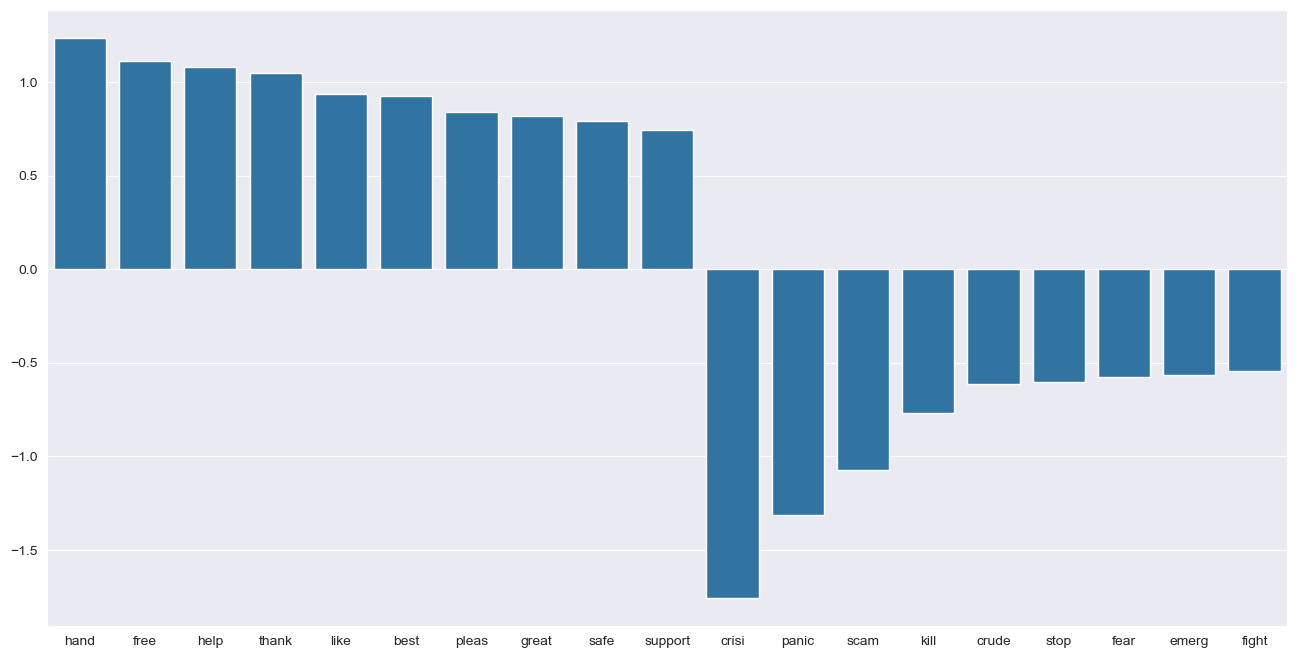

In [52]:
words = np.concatenate((top10[:, 0], bot10[:, 0]))
weights = np.concatenate((top10[:, 1], bot10[:, 1])).astype(float)

plt.figure(figsize=(16, 8))
sns.barplot(x=words, y=weights)
plt.show()

**Ответ:** Качества ничем оказалось хуже, чем для других скалеров (уже не стал убирать его во всех предыдущих). Видимо StandardScaler хуже подходит для разреженных данных.
Выглядит так, что токены определились правильно. Сильно положительные токены связанны с позитивом, например thank, great, great, safe, support, а отрицательные с негативными токенами feat, panic, stop, crisis, scam и т.д.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [53]:
X_train.sample(10)[["UserName", "ScreenName"]]

,UserName,ScreenName
21526,30059,75011
12442,18881,63833
22416,31193,76145
7152,12485,57437
31718,42817,87769
12615,19094,64046
7211,12559,57511
17279,24824,69776
22625,31445,76397
18387,26166,71118


**Ответ:** Это бесполезные признаки, хранящие номер пользователя и устройства, которые не содержат в себе никакой информации об эмоциональной окраске предложения и, скорее всего, только дополнительно переобучат модель

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

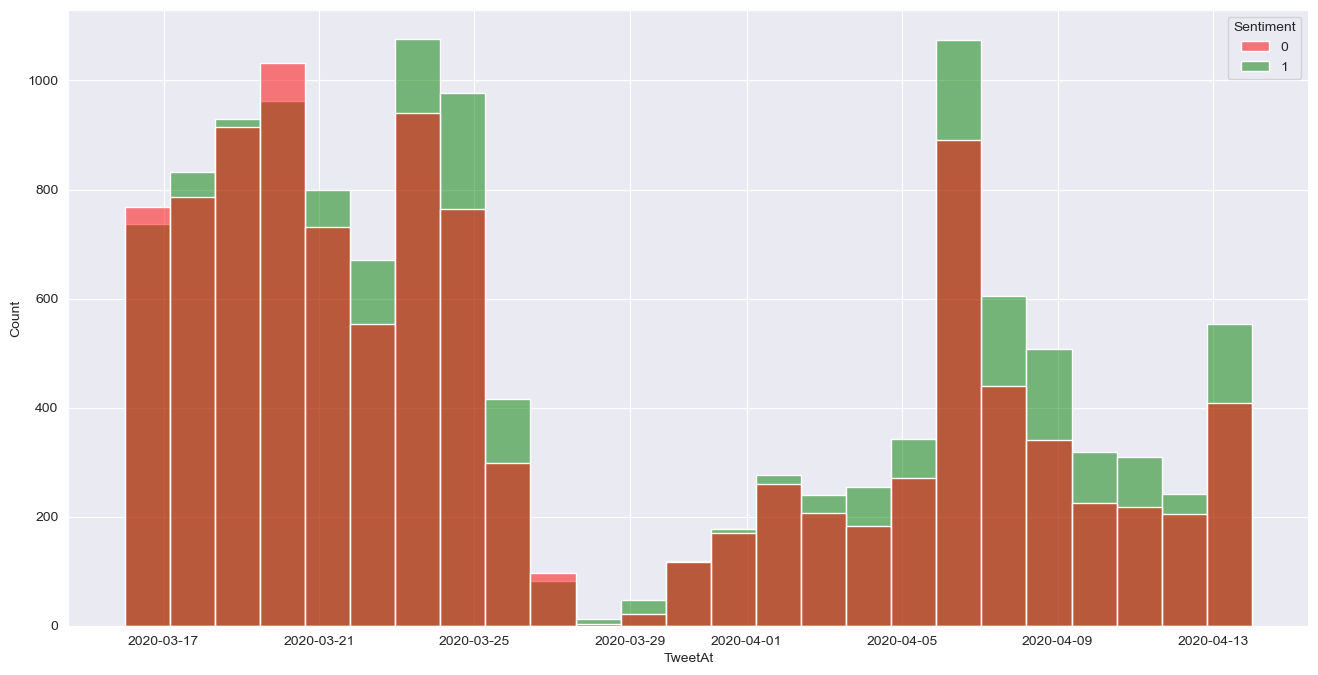

In [54]:
tweet_at = pd.to_datetime(X_train["TweetAt"], format='%d-%m-%Y')

plt.figure(figsize=(16, 8))
sns.histplot(x=tweet_at, hue=y_train, palette={0: 'red', 1: 'green'})
plt.show()

**Ответ:** Из гистограммы видно, что положительных и отрицательных постов всегда примерно одинаковое количество, только положительных постов зачастую чуть больше из-за дисбаланса класса. Нет явных дат, когда больше негативных (красных) или позитивных (зелёных) постов, отличается только их суммарное количество. То есть дата не даёт никакой информации для классификации и не должна быть использованы в модели.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [55]:
X_train["Location"].unique()  # почти 8000 уникальных значений

array(['Unknown', 'Boston, MA HQ', 'India', ..., 'Skipton, England',
       'lagos, NIGERIA', 'Waterville, Ireland Austin, TX'], dtype=object)

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

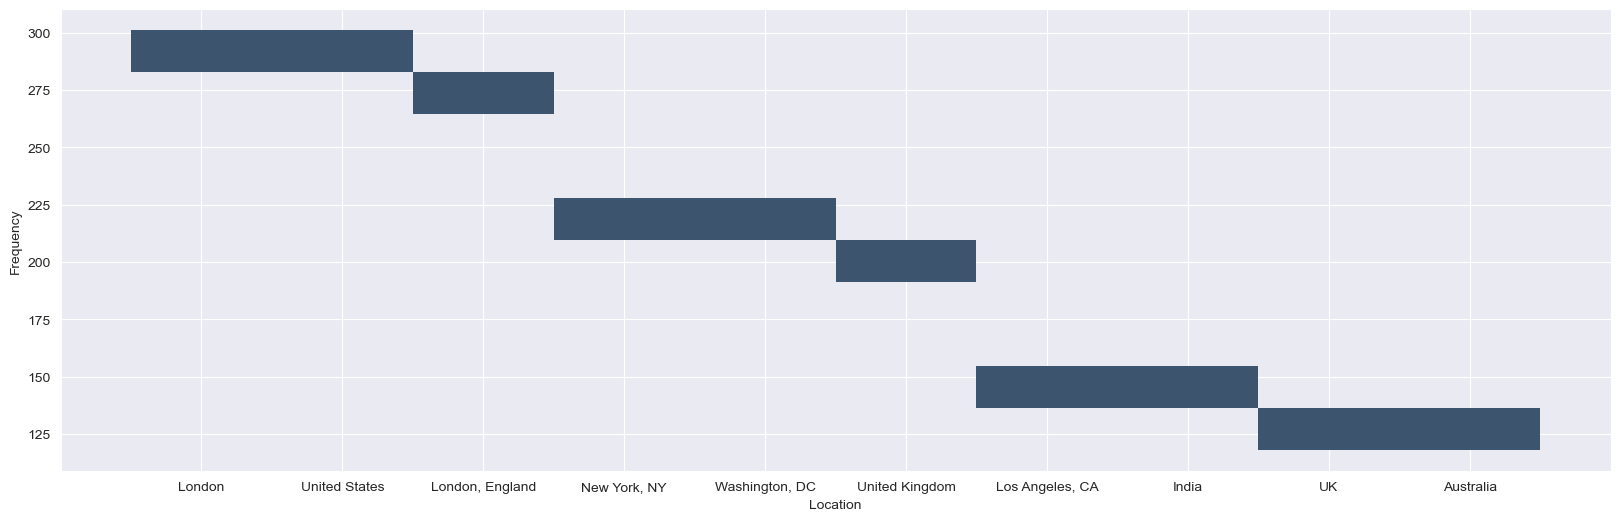

In [56]:
places = Counter(X_train["Location"])
del places["Unknown"]

top10_places = pd.DataFrame(places.most_common(10), columns=['Location', 'Frequency'])
plt.figure(figsize=(20, 6))
sns.histplot(data=top10_places, x="Location", y="Frequency", bins=10)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [71]:
# если в названии есть запятая, то добавляю последнее место, иначе ничего не меняю. Ещё делаю все буквы маленькими
X_train["WiderLocation"] = X_train["Location"].apply(lambda x: x.split(",")[-1].lower() if "," in x else x.lower())
X_test["WiderLocation"] = X_test["Location"].apply(lambda x: x.split(",")[-1].lower() if "," in x else x.lower())
display(X_train)
display(X_test)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,WiderLocation
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...,unknown
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...,ma hq
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,india
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...,uk
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh...",wnc
...,...,...,...,...,...,...
20757,29120,74072,Unknown,31-03-2020,Football is in ruins right now.When it will re...,unknown
32103,43291,88243,"Waterville, Ireland Austin, TX",13-04-2020,Hand sanitizer made here on the Skellig Coast!...,tx
30403,41159,86111,"Mumbai , Delhi India",10-04-2020,An initiative taken by our @GOLDENINITIATI1 ...,delhi india
21243,29702,74654,Unknown,01-04-2020,Vile premiership players demanding full wages ...,unknown


,UserName,ScreenName,Location,TweetAt,OriginalTweet,WiderLocation
28168,38343,83295,London,08-04-2020,What will the post-COVID-19 consumer look like...,london
19874,28015,72967,"Baltimore, MD",26-03-2020,It's crazy how going to the grocery store is s...,md
31702,42798,87750,"Tokyo-to, Japan",12-04-2020,Best online stores to buy things from Tokyo an...,japan
5110,10012,54964,Ohio,19-03-2020,#AngelaMerkel Nails #Coronavirus Speech ÃÂ U...,ohio
30081,40750,85702,"Detroit, MI",10-04-2020,Just saw someone at the grocery store lick the...,mi
...,...,...,...,...,...,...
5847,10903,55855,Yorkshire ÃÂ UK ÃÂ Europe,19-03-2020,As a supermarket assistant went through my bas...,yorkshire ãâ uk ãâ europe
3220,7693,52645,India,18-03-2020,#NewsAlert | The benchmark West Texas Intermed...,india
11637,17912,62864,Lexington/Phoenix,21-03-2020,ItÃÂs starting. Sh*tÃÂs getting weird.\r\r...,lexington/phoenix
21149,29590,74542,Unknown,01-04-2020,@henrymcmaster I work in a definitely nonessen...,unknown


In [72]:
X_train["WiderLocation"].unique()  # 4940

array(['unknown', ' ma hq', 'india', ..., 'nebraska', 'north texas',
       'whitehouse bar & pool room'], dtype=object)

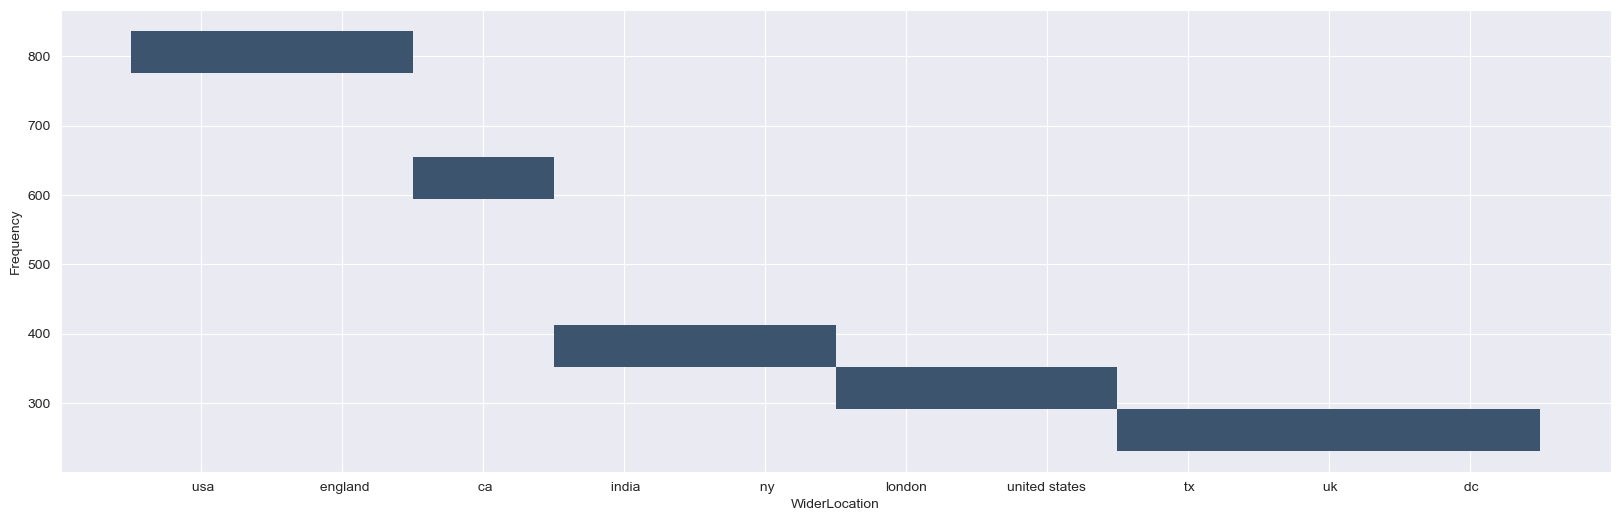

In [73]:
places = Counter(X_train["WiderLocation"])
del places["unknown"]

top10_places = pd.DataFrame(places.most_common(10), columns=['WiderLocation', 'Frequency'])
plt.figure(figsize=(20, 6))
sns.histplot(data=top10_places, x="WiderLocation", y="Frequency", bins=10)
plt.show()

In [135]:
# Хотел попробовать использовать geopy, но за 14 часов этот код не выполнился)
'''

from geopy.geocoders import Photon

def to_country(location):
    country = geolocator.geocode(location, timeout=None) 
    if country is not None and 'country' in country.raw["properties"]:
        return country.raw["properties"]["country"]
    return "Unknown"

geolocator = Photon(user_agent="geoapiExercises")
X_train["WiderLocation"] = X_train["Location"].apply(lambda x: to_country(x))

X_train
'''

'\n\nfrom geopy.geocoders import Photon\n\ndef to_country(location):\n    country = geolocator.geocode(location, timeout=None) \n    if country is not None and \'country\' in country.raw["properties"]:\n        return country.raw["properties"]["country"]\n    return "Unknown"\n\ngeolocator = Photon(user_agent="geoapiExercises")\nX_train["WiderLocation"] = X_train["Location"].apply(lambda x: to_country(x))\n\nX_train\n'

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [87]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", min_frequency=2)

widerLocation_train_encoded = enc.fit_transform(X_train[['WiderLocation']])
widerLocation_test_encoded = enc.transform(X_test[['WiderLocation']])

#X_train_encoded = pd.concat([X_train.drop(columns=['WiderLocation']), pd.DataFrame(widerLocation_train_encoded)], axis=0)
#X_test_encoded = pd.concat([X_test.drop(columns=['WiderLocation']), pd.DataFrame(widerLocation_test_encoded)], axis=0)

In [112]:
display(widerLocation_train_encoded)  # 1140 значений
display(widerLocation_test_encoded)

<23410x1140 sparse matrix of type '<class 'numpy.float64'>'
	with 23410 stored elements in Compressed Sparse Row format>

<10034x1140 sparse matrix of type '<class 'numpy.float64'>'
	with 8421 stored elements in Compressed Sparse Row format>

scipy.sparse._csr.csr_matrix

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [127]:
from scipy.sparse import hstack

cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00045, max_df=0.2) # использую лучшие параметры прошлых моделей
cv_df = cv.fit(X_train.OriginalTweet)

count_bow_train = cv.transform(X_train.OriginalTweet)
count_bow_test = cv.transform(X_test.OriginalTweet)

# модели
count_clf = LogisticRegression(random_state=0)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)


# pred
count_clf.fit(hstack([count_bow_train, widerLocation_train_encoded]), y_train)
count_pred_train = count_clf.predict(hstack([count_bow_train, widerLocation_train_encoded]))
count_pred_test = count_clf.predict(hstack([count_bow_test, widerLocation_test_encoded]))

In [129]:
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}")
print(f"test: {accuracy_score(y_test, count_pred_test)}")
# было:
# train: 0.9169585647159334
# test: 0.8618696432130756

CountVectorizer
train: 0.9227680478428022
test: 0.8579828582818417


**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [136]:
# можно изменить модель, так что воспользуюсь градиентным бустингом с изменённым скалером
from sklearn.ensemble import GradientBoostingClassifier
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00045, max_df=0.2) # использую лучшие параметры  прошлых моделей
cv_df = cv.fit(X_train.OriginalTweet)

count_bow_train = cv.transform(X_train.OriginalTweet)
count_bow_test = cv.transform(X_test.OriginalTweet)

# модели
count_clf = GradientBoostingClassifier(random_state=0, n_estimators=5000)

# Scaler
scaler = MaxAbsScaler()
# count
count_bow_train = scaler.fit_transform(count_bow_train)
count_bow_test = scaler.transform(count_bow_test)

# pred
# count
count_clf.fit(count_bow_train, y_train)
count_pred_train = count_clf.predict(count_bow_train)
count_pred_test = count_clf.predict(count_bow_test)

In [137]:
print("CountVectorizer")
print(f"train: {accuracy_score(y_train, count_pred_train)}") # 0.9867150790260573
print(f"test: {accuracy_score(y_test, count_pred_test)}") # 0.8836954355192346

CountVectorizer
train: 0.9867150790260573
test: 0.8836954355192346
